<a href="https://colab.research.google.com/github/olumideadekunle/Transformer-Architecture-Part-2_Scratch/blob/main/Transformer_Architecture_Part_2_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

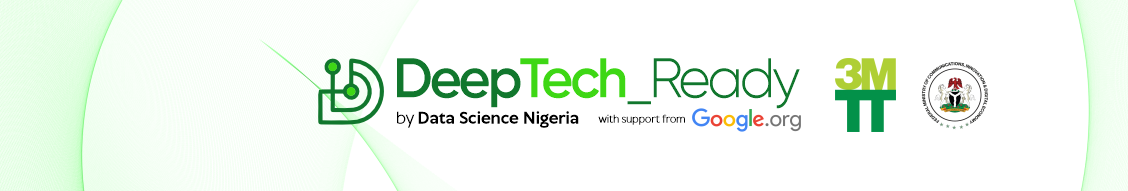

## Training Transformer Model for Machine Translation (Scratch)

## 0. Import Libraries and Setup

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import Transformer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

# Transformer Model for Machine Translation (English to French)

This project implements a Transformer-based sequence-to-sequence model from scratch for machine translation, specifically translating English sentences to French. The implementation showcases the core components of the Transformer architecture, including tokenization, embedding, positional encoding, multi-head attention, and feed-forward networks.

## Key Features:

- **Data Preparation**: Downloads and processes an English-French parallel corpus (`fra.txt`) from [manythings.org](http://www.manythings.org/anki/fra-eng.zip).
- **Custom Tokenization and Vocabulary**: Includes a custom tokenizer and vocabulary builder to handle sentence encoding and decoding.
- **PyTorch Dataset and DataLoader**: Manages data loading and batching with custom `TranslationDataset` and `collate_fn` for padding.
- **Transformer Architecture**: Implements a `TransformerSeq2Seq` model using PyTorch's `nn.Transformer` module, along with custom embedding and positional encoding layers.
- **Training and Validation**: Trains the model over multiple epochs with Adam optimizer and CrossEntropyLoss, tracking training and validation loss/accuracy.
- **Performance Visualization**: Plots training and validation loss and accuracy curves to monitor model performance.
- **BLEU Score Evaluation**: Evaluates the model's translation quality using the BLEU score metric.

## How to Use:

1. **Clone the Repository**:
   ```bash
   git clone <repository-url>
   cd <repository-name>
   ```
2. **Install Dependencies**:
   ```bash
   pip install torch pandas matplotlib nltk tqdm
   ```
3. **Run the Jupyter Notebook / Colab**:
   Open and run the provided notebook, which will guide you through data download, preprocessing, model training, and evaluation.

## Results:

The project demonstrates the feasibility of building and training a Transformer model for a basic machine translation task. The loss and accuracy curves provide insights into the training process, and the BLEU score quantifies the translation quality (though it might require further optimization for higher scores).


## 1. Data Preparation

### Download the dataset
We'll download the `fra.txt` file, which is a common English-French parallel corpus, from manythings.org.

In [ ]:
# Download the dataset
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d ./


--2025-11-13 12:33:42--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8186368 (7.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.81M  20.8MB/s    in 0.4s    

2025-11-13 12:33:43 (20.8 MB/s) - ‘fra-eng.zip’ saved [8186368/8186368]

Archive:  fra-eng.zip
  inflating: ./_about.txt            
  inflating: ./fra.txt               


### Convert the text file to `english_french.csv`

Now, we'll read the downloaded text file, parse it into English and French sentences, and save it as `english_french.csv`, which is the format expected by the existing code.

In [ ]:
import pandas as pd

# Read the text file
with open('fra.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Process lines into English and French sentences
source_sentences = []
target_sentences = []

for line in lines:
    parts = line.strip().split('\t')
    if len(parts) >= 2:
        source_sentences.append(parts[0])  # English sentence
        target_sentences.append(parts[1])  # French sentence

# Create a DataFrame
df = pd.DataFrame({
    'English': source_sentences,
    'French': target_sentences
})

# Save the DataFrame to a CSV file
df.to_csv('english_french.csv', index=False)

print("english_french.csv has been created successfully!")

# Display the first few rows of the created CSV to verify
df_check = pd.read_csv('english_french.csv')
print("\nFirst 5 rows of the created CSV:")
display(df_check.head())


english_french.csv has been created successfully!

First 5 rows of the created CSV:


,English,French
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


## 2. Tokenization and Vocabulary

In [ ]:

# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

## 3. Dataset and DataLoader

In [ ]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

## 4. Model Definition

In [ ]:

# === MODEL DEFINITION ===
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 5. Training and Validation

In [ ]:

# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 | Train Loss: 2.1361, Val Loss: 0.6027 | Train Acc: 0.7502, Val Acc: 0.9427


Epoch 2 | Train Loss: 0.3853, Val Loss: 0.4073 | Train Acc: 0.9556, Val Acc: 0.9689


Epoch 3 | Train Loss: 0.1671, Val Loss: 0.3828 | Train Acc: 0.9742, Val Acc: 0.9764


Epoch 4 | Train Loss: 0.0787, Val Loss: 0.3958 | Train Acc: 0.9843, Val Acc: 0.9795


Epoch 5 | Train Loss: 0.0422, Val Loss: 0.4053 | Train Acc: 0.9915, Val Acc: 0.9807


Epoch 6 | Train Loss: 0.0354, Val Loss: 0.3966 | Train Acc: 0.9926, Val Acc: 0.9806


Epoch 7 | Train Loss: 0.0381, Val Loss: 0.3817 | Train Acc: 0.9915, Val Acc: 0.9806


Epoch 8 | Train Loss: 0.0353, Val Loss: 0.3750 | Train Acc: 0.9919, Val Acc: 0.9802


Epoch 9 | Train Loss: 0.0327, Val Loss: 0.3619 | Train Acc: 0.9925, Val Acc: 0.9806


Epoch 10 | Train Loss: 0.0318, Val Loss: 0.3497 | Train Acc: 0.9925, Val Acc: 0.9804


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import Transformer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

In [ ]:
# === DATA PREPARATION ===
# Load the CSV file
df = pd.read_csv('english_french.csv')

# Extract English and French sentences
#source_sentences = df['English'].tolist()
#target_sentences = df['French'].tolist()


# Sample 10% of the data for illustration
df_sampled = df.sample(frac=0.1, random_state=42)

# Extract English and French sentences
source_sentences = df_sampled['English'].tolist()
target_sentences = df_sampled['French'].tolist()

# Check the sampled data size
print(f"Sampled data size: {len(df_sampled)}")

Sampled data size: 23919


In [ ]:

# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

In [ ]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:

# === MODEL DEFINITION ===
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1 | Train Loss: 5.9053, Val Loss: 4.7088 | Train Acc: 0.2596, Val Acc: 0.4031


Epoch 2 | Train Loss: 3.9525, Val Loss: 3.2878 | Train Acc: 0.4773, Val Acc: 0.5953


Epoch 3 | Train Loss: 2.5598, Val Loss: 2.2555 | Train Acc: 0.6473, Val Acc: 0.7343


Epoch 4 | Train Loss: 1.5439, Val Loss: 1.6407 | Train Acc: 0.7736, Val Acc: 0.8162


Epoch 5 | Train Loss: 0.8872, Val Loss: 1.3336 | Train Acc: 0.8572, Val Acc: 0.8607


Epoch 6 | Train Loss: 0.4783, Val Loss: 1.2307 | Train Acc: 0.9201, Val Acc: 0.8821


Epoch 7 | Train Loss: 0.2413, Val Loss: 1.2103 | Train Acc: 0.9639, Val Acc: 0.8943


Epoch 8 | Train Loss: 0.1190, Val Loss: 1.2286 | Train Acc: 0.9836, Val Acc: 0.8999


Epoch 9 | Train Loss: 0.0752, Val Loss: 1.2455 | Train Acc: 0.9886, Val Acc: 0.9047


Epoch 10 | Train Loss: 0.0569, Val Loss: 1.2778 | Train Acc: 0.9907, Val Acc: 0.9073


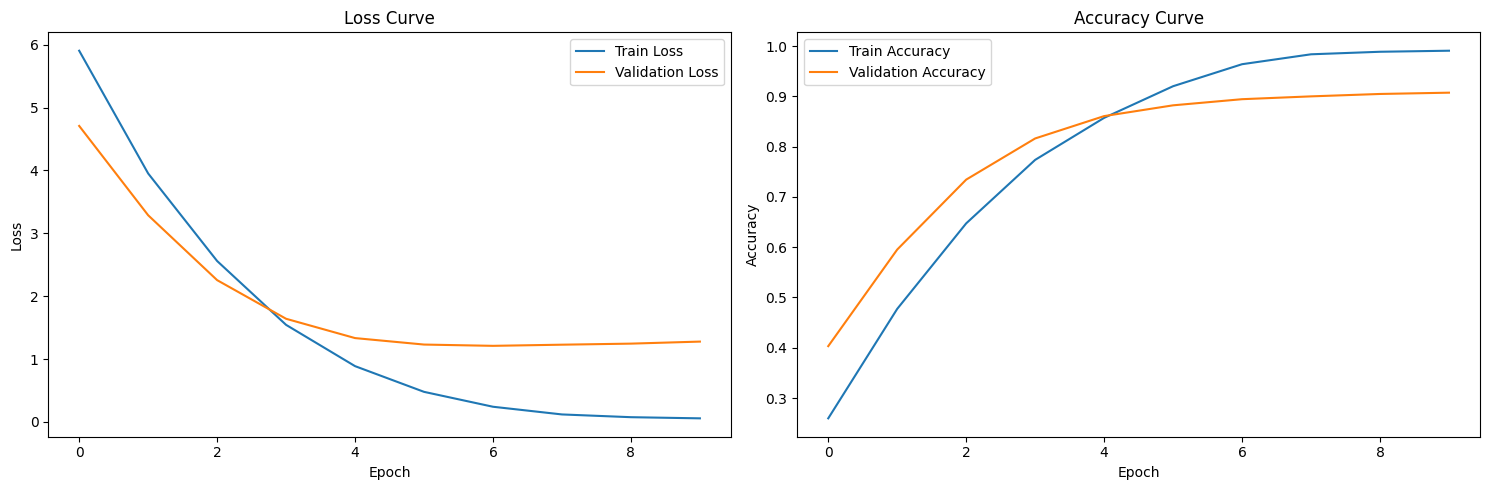

In [ ]:
# === PLOTTING RESULTS ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# === BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import Transformer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

In [ ]:
# === DATA PREPARATION ===
# Load the CSV file
df = pd.read_csv('english_french.csv')

# Extract English and French sentences
#source_sentences = df['English'].tolist()
#target_sentences = df['French'].tolist()


# Sample 1% of the data for illustration
df_sampled = df.sample(frac=0.01, random_state=42)

# Extract English and French sentences
source_sentences = df_sampled['English'].tolist()
target_sentences = df_sampled['French'].tolist()

# Check the sampled data size
print(f"Sampled data size: {len(df_sampled)}")

Sampled data size: 2392


In [ ]:

# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

In [ ]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:

# === MODEL DEFINITION ===
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 | Train Loss: 6.9217, Val Loss: 6.4067 | Train Acc: 0.1451, Val Acc: 0.1477


Epoch 2 | Train Loss: 6.0419, Val Loss: 6.2851 | Train Acc: 0.1542, Val Acc: 0.1645


Epoch 3 | Train Loss: 5.6701, Val Loss: 6.0141 | Train Acc: 0.1933, Val Acc: 0.2219


Epoch 4 | Train Loss: 5.2247, Val Loss: 5.7846 | Train Acc: 0.2514, Val Acc: 0.2530


Epoch 5 | Train Loss: 4.8068, Val Loss: 5.6179 | Train Acc: 0.2898, Val Acc: 0.2760


Epoch 6 | Train Loss: 4.4062, Val Loss: 5.4774 | Train Acc: 0.3263, Val Acc: 0.2999


Epoch 7 | Train Loss: 4.0640, Val Loss: 5.3924 | Train Acc: 0.3600, Val Acc: 0.3206


Epoch 8 | Train Loss: 3.7339, Val Loss: 5.3470 | Train Acc: 0.3879, Val Acc: 0.3372


Epoch 9 | Train Loss: 3.3995, Val Loss: 5.3313 | Train Acc: 0.4218, Val Acc: 0.3426


Epoch 10 | Train Loss: 3.1042, Val Loss: 5.2757 | Train Acc: 0.4466, Val Acc: 0.3522


In [ ]:
# === BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):  # Max translation length
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000


In [ ]:
# === DATA PREPARATION ===
# Load the CSV file
df = pd.read_csv('english_french.csv')

# Extract English and French sentences
#source_sentences = df['English'].tolist()
#target_sentences = df['French'].tolist()


# Sample 1% of the data for illustration
df_sampled = df.sample(frac=0.01, random_state=42)

# Extract English and French sentences
source_sentences = df_sampled['English'].tolist()
target_sentences = df_sampled['French'].tolist()

# Check the sampled data size
print(f"Sampled data size: {len(df_sampled)}")

Sampled data size: 2392


In [ ]:

# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

In [ ]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:

# === MODEL DEFINITION ===
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:

# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 | Train Loss: 6.9231, Val Loss: 6.3971 | Train Acc: 0.1437, Val Acc: 0.1520


Epoch 2 | Train Loss: 6.0474, Val Loss: 6.2728 | Train Acc: 0.1529, Val Acc: 0.1784


Epoch 3 | Train Loss: 5.6999, Val Loss: 5.9993 | Train Acc: 0.1943, Val Acc: 0.2281


Epoch 4 | Train Loss: 5.2657, Val Loss: 5.7651 | Train Acc: 0.2461, Val Acc: 0.2573


Epoch 5 | Train Loss: 4.8551, Val Loss: 5.6021 | Train Acc: 0.2880, Val Acc: 0.2790


Epoch 6 | Train Loss: 4.4719, Val Loss: 5.4658 | Train Acc: 0.3231, Val Acc: 0.2955


Epoch 7 | Train Loss: 4.1240, Val Loss: 5.3835 | Train Acc: 0.3493, Val Acc: 0.3135


Epoch 8 | Train Loss: 3.7776, Val Loss: 5.3129 | Train Acc: 0.3833, Val Acc: 0.3289


Epoch 9 | Train Loss: 3.4571, Val Loss: 5.2499 | Train Acc: 0.4108, Val Acc: 0.3457


Epoch 10 | Train Loss: 3.1556, Val Loss: 5.2279 | Train Acc: 0.4407, Val Acc: 0.3556


In [ ]:
# === BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):  # Max translation length
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000


## Plot Validation Curves

## BLEU SCORE EVALUATION

In [39]:
# === BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):  # Max translation length
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000
